# Average Detected Vegetation Line (AVDLs)
In this file we:
<ol>
<li> Calculate the AVDLs for Bull Island in 2017, 2019 and 2021
<li> Format the results for input into DSAS, for:
<ul> 
<li> Erosion rate calculations 
<li> Distance calculations between pairs of manually annotated vegetaion lines (MAVLs) and ADVLs in each year
</ul>
</ol>


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rasterio
from shapely.geometry import LineString
import geopandas as gpd

from collections import deque
from scipy.ndimage import label
from skimage.graph import route_through_array

import os
import glob
from tqdm import tqdm

# Import helper files
import utils 
import importlib
importlib.reload(utils)

import evaluation as eval
importlib.reload(eval)

data_path = "/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data"

In [2]:
# Points dictionary
points_dict = np.load('../data/SIVE/erosion_points_dict.npy', allow_pickle=True).item()
points_dict.keys()

dict_keys(['20210721T113319_bull_island', '20210719T114351_bull_island', '20210716T113321_bull_island', '20210629T114351_bull_island', '20210621T113319_bull_island', '20210530T114351_bull_island', '20210507T113321_bull_island', '20210422T113309_bull_island', '20210417T113311_bull_island', '20210415T114349_bull_island', '20210331T114351_bull_island', '20210326T114349_bull_island', '20210316T114349_bull_island', '20210313T113319_bull_island', '20210311T114351_bull_island', '20210226T113321_bull_island', '20190831T113319_bull_island', '20190826T113321_bull_island', '20190715T114359_bull_island', '20190707T113321_bull_island', '20190627T113321_bull_island', '20190421T114351_bull_island', '20190413T113329_bull_island', '20190411T114351_bull_island', '20190406T114349_bull_island', '20190329T113321_bull_island', '20190327T114349_bull_island', '20170717T113321_bull_island', '20170712T113319_bull_island', '20170620T114351_bull_island', '20170617T113321_bull_island', '20170408T113321_bull_island

In [3]:
# Load the model
best_model_name= "SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth"
model_path = f'../models/SIVE_04JUN2025/{best_model_name}'
model, meta_data = utils.get_model(model_path)

In [4]:
def get_dates(path):
    ID = os.path.basename(path).split('_')[2]
    year = ID[0:4]
    month = ID[4:6]
    day = ID[6:8]
    date = f"{year}-{month}-{day}"
    return pd.to_datetime(date)

erosion_path = os.path.join(data_path, 'raw/erosion/')
erosion_paths = glob.glob(erosion_path + '*.SAFE')
erosion_paths = [os.path.basename(path) for path in erosion_paths]
print(f"Number of erosion files: {len(erosion_paths)}")

# Dates should be in 6 month range of when MAVLs where taken
erosion_dates = [get_dates(path) for path in erosion_paths]
pd.DataFrame({'date': erosion_dates, 'path': erosion_paths}).sort_values(by='date').reset_index(drop=True)

Number of erosion files: 33


date                                               path
0  2017-03-27  S2B_MSIL2A_20170327T114349_N0500_R009_T29UPV_2...
1  2017-04-08  S2A_MSIL2A_20170408T113321_N0500_R080_T29UPV_2...
2  2017-06-17  S2A_MSIL2A_20170617T113321_N0500_R080_T29UPV_2...
3  2017-06-20  S2A_MSIL2A_20170620T114351_N0500_R123_T29UPV_2...
4  2017-07-12  S2B_MSIL2A_20170712T113319_N0500_R080_T29UPV_2...
5  2017-07-17  S2A_MSIL2A_20170717T113321_N0500_R080_T29UPV_2...
6  2019-03-27  S2B_MSIL2A_20190327T114349_N0500_R123_T29UPV_2...
7  2019-03-29  S2A_MSIL2A_20190329T113321_N0500_R080_T29UPV_2...
8  2019-04-06  S2B_MSIL2A_20190406T114349_N0500_R123_T29UPV_2...
9  2019-04-11  S2A_MSIL2A_20190411T114351_N0500_R123_T29UPV_2...
10 2019-04-13  S2B_MSIL2A_20190413T113329_N0500_R080_T29UPV_2...
11 2019-04-21  S2A_MSIL2A_20190421T114351_N0500_R123_T29UPV_2...
12 2019-06-27  S2A_MSIL2A_20190627T113321_N0500_R080_T29UPV_2...
13 2019-07-07  S2A_MSIL2A_20190707T113321_N0500_R080_T29UPV_2...
14 2019-07-15  S2B_MSIL2A_20190715T114359_N0500_R123_T29UPV_2...
15 2019-08-26  S2A_MSIL2A_20190826T113321_N0500_R080_T29UPV_2...
16 2019-08-31  S2B_MSIL2A_20190831T113319_N0500_R080_T29UPV_2...
17 2021-02-26  S2A_MSIL2A_20210226T113321_N0500_R080_T29UPV_2...
18 2021-03-11  S2A_MSIL2A_20210311T114351_N0500_R123_T29UPV_2...
19 2021-03-13  S2B_MSIL2A_20210313T113319_N0500_R080_T29UPV_2...
20 2021-03-16  S2B_MSIL2A_20210316T114349_N0500_R123_T29UPV_2...
21 2021-03-26  S2B_MSIL2A_20210326T114349_N0500_R123_T29UPV_2...
22 2021-03-31  S2A_MSIL2A_20210331T114351_N0500_R123_T29UPV_2...
23 2021-04-15  S2B_MSIL2A_20210415T114349_N0500_R123_T29UPV_2...
24 2021-04-17  S2A_MSIL2A_20210417T113311_N0500_R080_T29UPV_2...
25 2021-04-22  S2B_MSIL2A_20210422T113309_N0500_R080_T29UPV_2...
26 2021-05-07  S2A_MSIL2A_20210507T113321_N0500_R080_T29UPV_2...
27 2021-05-30  S2A_MSIL2A_20210530T114351_N0500_R123_T29UPV_2...
28 2021-06-21  S2B_MSIL2A_20210621T113319_N0500_R080_T29UPV_2...
29 2021-06-29  S2A_MSIL2A_20210629T114351_N0500_R123_T29UPV_2...
30 2021-07-16  S2A_MSIL2A_20210716T113321_N0500_R080_T29UPV_2...
31 2021-07-19  S2A_MSIL2A_20210719T114351_N0500_R123_T29UPV_2...
32 2021-07-21  S2B_MSIL2A_20210721T113319_N0500_R080_T29UPV_2...

## Functions for VL processing

In [5]:
# 8-connected neighbor offsets
NEIGHBOR_OFFSETS = [(-1, -1), (-1, 0), (-1, 1),
                    (0, -1),           (0, 1),
                    (1, -1),  (1, 0),  (1, 1)]

def build_adjacency(edge_map):
    """Build adjacency dictionary for each edge pixel in the edge map. 
    Each key is a pixel coordinate (y, x) and the value is a list of neighboring coordinates.
    """
    edge_map = edge_map.astype(np.uint8)
    coords = [tuple(c) for c in np.argwhere(edge_map > 0)] # We are interested in the edge pixels
    coord_set = set(coords)
    adj = {}
    for y, x in coords:
        neighbors = [(y+dy, x+dx) for dy, dx in NEIGHBOR_OFFSETS
                     if (y+dy, x+dx) in coord_set]
        adj[(y, x)] = neighbors
    return adj

def find_endpoints(adj):
    """Return list of endpoints. These are edge pixels with exactly 1 neighbor."""
    return [p for p, nbrs in adj.items() if len(nbrs) == 1]

def connect_components_shortest_path(binary_map):
    """
    Connect disconnected components in a binary map using the shortest path.

    Parameters:
        binary_map (numpy.ndarray): 2D array of 0s and 1s.

    Returns:
        numpy.ndarray: Updated binary map with all components connected.
    """
    # Ensure input is binary
    binary_map = (binary_map > 0).astype(np.uint8)

    # Label connected components
    structure = np.ones((3, 3), dtype=np.uint8)  # 8-connected neighbourhood
    labeled, num_features = label(binary_map, structure=structure)
    if num_features <= 1:
        return binary_map  # Already connected

    # We'll iteratively connect components until only one remains
    while num_features > 1:
        # Get coordinates of the first component
        coords1 = np.argwhere(labeled == 1)
        
        min_dist = np.inf
        best_pair = None
        
        # Compare to all other components
        for comp_id in range(2, num_features + 1):
            coords2 = np.argwhere(labeled == comp_id)

            # Compute pairwise distances (brute force)
            for p1 in coords1:
                for p2 in coords2:
                    dist = np.sum((p1 - p2) ** 2)  # squared distance
                    if dist < min_dist:
                        min_dist = dist
                        best_pair = (tuple(p1), tuple(p2))
        
        # Create a cost array where 0s have low cost and 1s have high cost
        # This ensures path goes mostly through 0s
        cost_array = np.where(binary_map == 0, 1, 10)

        # Find shortest path between the closest pixels
        start, end = best_pair
        path, _ = route_through_array(cost_array, start, end, fully_connected=True)
        path = np.array(path)

        # Set path pixels to 1
        binary_map[path[:, 0], path[:, 1]] = 1

        # Recompute connected components
        labeled, num_features = label(binary_map, structure=structure)

    return binary_map

def bfs_longest_path(adj, start):
    """Breadth-first search to find the longest path from a starting point."""

    visited = {start: None} # Dictionary to track visited nodes and their parents
    q = deque([start]) # Initialize the queue with the starting node
    while q:
        node = q.popleft() # Get the next node from the queue
        for nbr in adj[node]:  # Iterate over neighbors of the node 
            if nbr not in visited: 
                visited[nbr] = node 
                q.append(nbr)

    # Farthest node found
    farthest = node # the farthest node will be the last node processed

    # Reconstruct path. This will be the longest path from the start node. 
    path = []
    while farthest is not None:
        path.append(farthest)
        farthest = visited[farthest]
    return path[::-1]  # Return the path in the correct order (from start to farthest node)

def clean_edge_skeleton(skel):
    """
    Remove tangents/junctions from skeleton to produce:
    - exactly 2 endpoints
    - all other points have degree 2
    Returns:
        cleaned_skel (binary array)
        ordered_coords (list of (y, x) pixels from endpoint to endpoint)
    """
    adj = build_adjacency(skel)
    endpoints = find_endpoints(adj)
    if len(endpoints) < 2:
        raise ValueError(f"Expected at least 2 endpoints, found {len(endpoints)}")

    # Find the longest path from any endpoint. The longest line should connect the real endpoints.
    max_path = []
    for ep in endpoints:
        path = bfs_longest_path(adj, ep)
        if len(path) > len(max_path):
            max_path = path

    # Keep only pixels in longest path
    cleaned = np.zeros_like(skel, dtype=np.uint8)
    for y, x in max_path:
        cleaned[y, x] = 1

    return cleaned, max_path

# Convert pixel coordinates to utm coordinates
def pixel_to_utm(pixel_coords, raster_path):
    """
    Convert pixel coordinates to utm coordinates using the raster transform.
    """
    with rasterio.open(raster_path) as src:

        utm_coords = []
        for y,x in pixel_coords:
            utm_x, utm_y = src.xy(y,x)  # Note: rasterio uses (row, col) order
            utm_coords.append((utm_x, utm_y))

        crs = src.crs  # Get the CRS from the raster file

        return utm_coords, crs

### Step 1: Get individual detected vegetation lines

In [6]:
# Test data
target_pos = -1

test_file = '../data/processed/aoi_stacked/erosion/'
test_paths = glob.glob(test_file + '*.npy')
test_paths.sort()
print(f"Number of test files: {len(test_paths)}")

Number of test files: 33


100%|██████████| 33/33 [00:09<00:00,  3.39it/s]


Text(0.5, 1.0, 'Cleaned')

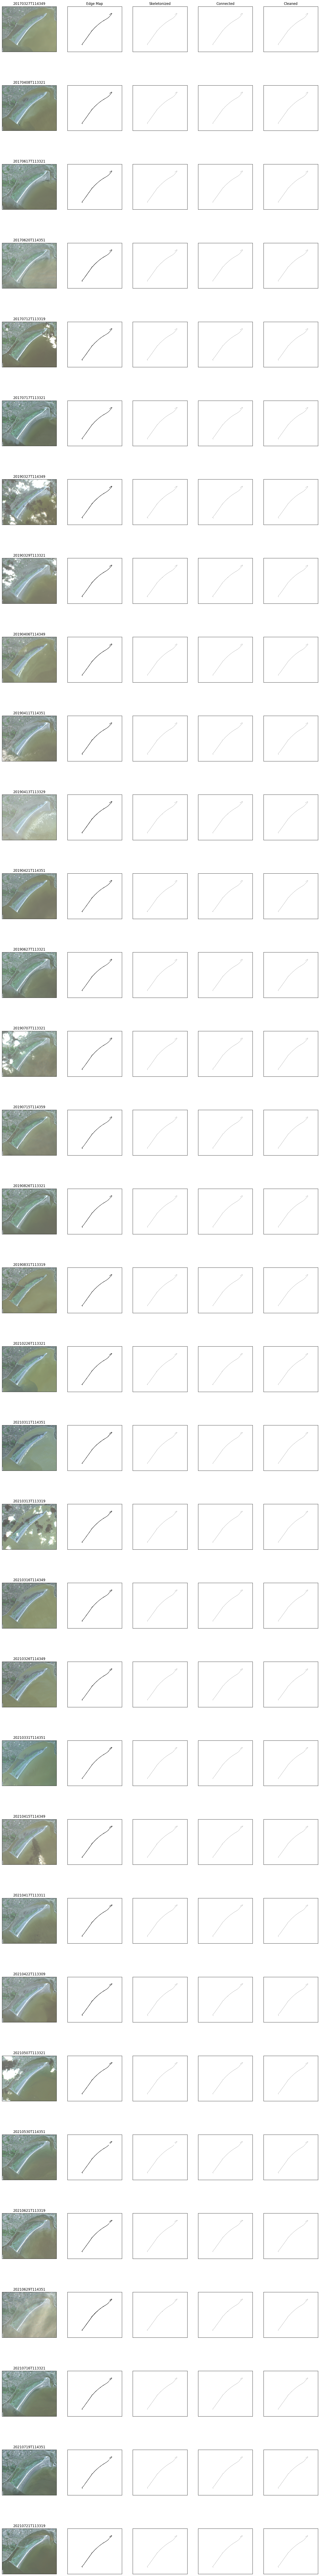

In [7]:
fig, ax = plt.subplots(len(test_paths), 5, figsize=(5*4, 5*len(test_paths)))

crop = 200

images = []
cleaned_edges = []
ordered_coords = []

for i,path in tqdm(enumerate(test_paths), total=len(test_paths)):

    ID = os.path.basename(path).split('_')[0]

    # Get vegetation line prediction
    image, edge_map = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1,post_process=False)

    # Clean the edge map
    skel_edge_map = utils.thin_edge_map(edge_map)
    connected_edge_map = connect_components_shortest_path(skel_edge_map)
    cleaned_edge, ordered_coord = clean_edge_skeleton(connected_edge_map)

    # Add to list 
    images.append(image)
    cleaned_edges.append(cleaned_edge)
    ordered_coords.append(ordered_coord)

    # Get RGB image
    rgb = utils.get_rgb(image, contrast=0.3)

    # Remove pixel buffer 
    if crop > 0:
        rgb = rgb[crop:-crop, crop:-crop, :]
        edge_map = edge_map[crop:-crop, crop:-crop]
        skel_edge_map = skel_edge_map[crop:-crop, crop:-crop]
        connected_edge_map = connected_edge_map[crop:-crop, crop:-crop]
        cleaned_edge = cleaned_edge[crop:-crop, crop:-crop]

    # Plot each result to ensure a reasonable detected VL
    ax[i, 0].imshow(rgb)
    ax[i, 0].set_title(f"{ID}")
    ax[i, 1].imshow(1-edge_map,cmap='gray')
    ax[i, 2].imshow(1-skel_edge_map,cmap='gray')
    ax[i, 3].imshow(1-connected_edge_map,cmap='gray')
    ax[i, 4].imshow(1-cleaned_edge,cmap='gray')

    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

ax[0, 1].set_title(f"Edge Map", fontsize=12)
ax[0, 2].set_title(f"Skeletonized", fontsize=12)
ax[0, 3].set_title(f"Connected", fontsize=12)
ax[0, 4].set_title(f"Cleaned", fontsize=12)


### Step 2: Create GeoDataFrame from individual vegetation lines

In [8]:
def interpolate_line_relative(line, num_points=5000):
    # Interpolate points based on relative distance along the line (0 to 1)
    relative_distances = np.linspace(0, 1, num_points)
    line = [line.interpolate(rd * line.length) for rd in relative_distances]
    line = LineString(line)
    return line

In [9]:
def trim_line_to_start(line, start_point=(688621, 5915318),end_point=None): 
    """
    Trim the line so it starts at the point closest to the given start point.
    """
    if not isinstance(line, LineString):
        raise ValueError("Input must be a LineString geometry.")

    # Get coordinates of the line
    coords = np.array(line.coords)

    # Find the index of the point closest to the start point
    distances = np.linalg.norm(coords - np.array(start_point), axis=1)
    start_index = np.argmin(distances)

    # Create a new LineString starting from the closest point
    trimmed_coords = coords[start_index:]

    if end_point is not None:
        # Find the index of the point closest to the end point
        distances = np.linalg.norm(trimmed_coords - np.array(end_point), axis=1)
        end_index = np.argmin(distances)

        # Trim the line to the end point
        trimmed_coords = trimmed_coords[:end_index + 1]
    return LineString(trimmed_coords)

In [11]:
detected_vegetation_lines = gpd.GeoDataFrame(columns=['geometry', 'ID', 'year'])

for i, path in tqdm(enumerate(test_paths), total=len(test_paths)):
    ID = os.path.basename(path).split('_')[0]
    year = ID[0:4]
    raster_path = path.replace('.npy', '.tif')

    utm_coords, crs = pixel_to_utm(ordered_coords[i], raster_path)
    line = LineString(utm_coords)
    
    # Reverse the line
    line = LineString(list(line.coords)[::-1])

    # Resample line with 100000 points
    line = interpolate_line_relative(line, num_points=100000)

     # Trim the line to start at the given point
    line = trim_line_to_start(line, start_point=(688619, 5915319), end_point=(691692, 5918617))

    new_row = gpd.GeoDataFrame(
        [{'geometry': line, 'ID': ID, 'year': year}],
        crs=crs
    )

    detected_vegetation_lines = pd.concat([detected_vegetation_lines, new_row], ignore_index=True)


detected_vegetation_lines = detected_vegetation_lines.set_crs(crs)
detected_vegetation_lines.to_file('../data/processed/vegetation_lines/detected_vegetation_lines.shp', driver='ESRI Shapefile')
detected_vegetation_lines.head()


100%|██████████| 33/33 [03:35<00:00,  6.53s/it]


geometry               ID  year
0  LINESTRING (688619.01 5915319.01, 688619.048 5...  20170327T114349  2017
1  LINESTRING (688618.995 5915318.995, 688619.033...  20170408T113321  2017
2  LINESTRING (688619.016 5915319.016, 688619.054...  20170617T113321  2017
3  LINESTRING (688619.007 5915319.007, 688619.046...  20170620T114351  2017
4  LINESTRING (688618.981 5915318.981, 688619.019...  20170712T113319  2017

### Step 3: Calculate average detected vegetation lines (ADVLs)

In [12]:
detected_vegetation_lines = gpd.read_file('../data/processed/vegetation_lines/detected_vegetation_lines.shp')

# Check if lengths are reasonable
detected_vegetation_lines['length'] = detected_vegetation_lines.geometry.length.round(0)

# Calculate average length per year
length_per_year = detected_vegetation_lines.groupby('year')['length'].mean().reset_index()
length_per_year

year       length
0  2017  5246.500000
1  2019  5210.727273
2  2021  5217.687500

In [13]:
# Check if the length of every line is within 100m of the average length for that year
length_check = []
for row in detected_vegetation_lines.itertuples():
    year = row.year
    length = row.length

    year_avg = length_per_year[length_per_year['year'] == year]['length'].values[0]
    length_check.append(np.abs(length-year_avg)<100)

detected_vegetation_lines['length_check'] = length_check
detected_vegetation_lines

ID  year                                           geometry  \
0   20170327T114349  2017  LINESTRING (688619.01 5915319.01, 688619.048 5...   
1   20170408T113321  2017  LINESTRING (688618.995 5915318.995, 688619.033...   
2   20170617T113321  2017  LINESTRING (688619.016 5915319.016, 688619.054...   
3   20170620T114351  2017  LINESTRING (688619.007 5915319.007, 688619.046...   
4   20170712T113319  2017  LINESTRING (688618.981 5915318.981, 688619.019...   
5   20170717T113321  2017  LINESTRING (688619.009 5915319.009, 688619.048...   
6   20190327T114349  2019  LINESTRING (688623.993 5915313.993, 688624.032...   
7   20190329T113321  2019  LINESTRING (688623.983 5915313.983, 688624.022...   
8   20190406T114349  2019  LINESTRING (688624.009 5915314.009, 688624.047...   
9   20190411T114351  2019  LINESTRING (688618.994 5915318.994, 688619.032...   
10  20190413T113329  2019  LINESTRING (688618.988 5915318.988, 688619.026...   
11  20190421T114351  2019  LINESTRING (688619.012 5915319.012, 688619.05 ...   
12  20190627T113321  2019  LINESTRING (688619.01 5915319.01, 688619.048 5...   
13  20190707T113321  2019  LINESTRING (688619.007 5915319.007, 688619.046...   
14  20190715T114359  2019  LINESTRING (688619.005 5915319.005, 688619.043...   
15  20190826T113321  2019  LINESTRING (688623.989 5915313.989, 688624.027...   
16  20190831T113319  2019  LINESTRING (688620 5915318.979, 688620 5915319...   
17  20210226T113321  2021  LINESTRING (688618.981 5915318.981, 688619.019...   
18  20210311T114351  2021  LINESTRING (688620 5915318.974, 688620 5915319...   
19  20210313T113319  2021  LINESTRING (688619.015 5915319.015, 688619.053...   
20  20210316T114349  2021  LINESTRING (688620 5915319.023, 688620 5915319...   
21  20210326T114349  2021  LINESTRING (688630 5915319.011, 688630 5915319...   
22  20210331T114351  2021  LINESTRING (688623.997 5915313.997, 688624.035...   
23  20210415T114349  2021  LINESTRING (688620 5915319.018, 688620 5915319...   
24  20210417T113311  2021  LINESTRING (688618.996 5915318.996, 688619.035...   
25  20210422T113309  2021  LINESTRING (688623.996 5915313.996, 688624.035...   
26  20210507T113321  2021  LINESTRING (688623.992 5915313.992, 688624.031...   
27  20210530T114351  2021  LINESTRING (688618.987 5915318.987, 688619.025...   
28  20210621T113319  2021  LINESTRING (688618.99 5915318.99, 688619.028 5...   
29  20210629T114351  2021  LINESTRING (688614.014 5915324.014, 688614.052...   
30  20210716T113321  2021  LINESTRING (688620 5915318.978, 688620 5915319...   
31  20210719T114351  2021  LINESTRING (688620 5915319.015, 688620 5915319...   
32  20210721T113319  2021  LINESTRING (688618.986 5915320, 688619.041 591...   

    length  length_check  
0   5233.0          True  
1   5238.0          True  
2   5226.0          True  
3   5262.0          True  
4   5261.0          True  
5   5259.0          True  
6   5207.0          True  
7   5207.0          True  
8   5212.0          True  
9   5214.0          True  
10  5195.0          True  
11  5209.0          True  
12  5219.0          True  
13  5221.0          True  
14  5213.0          True  
15  5218.0          True  
16  5203.0          True  
17  5213.0          True  
18  5201.0          True  
19  5186.0          True  
20  5228.0          True  
21  5194.0          True  
22  5210.0          True  
23  5252.0          True  
24  5215.0          True  
25  5237.0          True  
26  5226.0          True  
27  5204.0          True  
28  5215.0          True  
29  5222.0          True  
30  5227.0          True  
31  5226.0          True  
32  5227.0          True

In [14]:
def average_lines(gdf_year, num_points):
    """
    Average multiple lines in a GeoDataFrame by resampling each line to the same number of points
    and interpolating the geometry.
    """
    all_coords = []
    for line in gdf_year.geometry:
        points = interpolate_line_relative(line, num_points)

        points = list(points.coords)  # Convert to list of coordinates
        #print(points)

        coords = np.array([[pt[0], pt[1]] for pt in points])
        all_coords.append(coords)

    # Stack and average
    all_coords = np.stack(all_coords)  # (n_lines, n_points, 2)
    avg_coords = np.mean(all_coords, axis=0)

    return LineString(avg_coords)

# Generate average lines for 2017, 2019 and 2021
average_vegetation_lines = []
for year in tqdm(detected_vegetation_lines['year'].unique()):
    gdf_year = detected_vegetation_lines[detected_vegetation_lines['year'] == year]
    avg_line = average_lines(gdf_year, num_points=10000)
    average_vegetation_lines.append({'year': year, 'geometry': avg_line})

average_vegetation_lines = gpd.GeoDataFrame(average_vegetation_lines, crs=crs)
average_vegetation_lines.to_file('../data/processed/vegetation_lines/average_vegetation_lines.shp', driver='ESRI Shapefile')

100%|██████████| 3/3 [05:52<00:00, 117.43s/it]


### Step 4: Process vegetation lines for DSAS

In [15]:
# Load manually annotated vegetation lines (MAVLs)
mavl_path = os.path.join(data_path, "QGIS Projects/DSAS Erosion Rates/DUBLIN 2000_2021_ITM/DUShorelines_OSi.shp")
mavl = gpd.read_file(mavl_path)
mavl

DATE_  OBJECTID                                       Shoreltype  \
0  06/06/2014         5                     Vegetation Line ITM/OSi 2014   
1  06/06/2013         4                     Vegetation Line ITM/OSi 2013   
2  08/09/2000         1                     Vegetation Line ITM/OSi 2000   
3  01/07/2011         3  Vegetation Line OSi ITM/DGlobe Dublin July 2011   
4  06/06/2019         7                     Vegetation Line ITM/OSi 2019   
5  03/07/2005         2                     Vegetation Line ITM/OSi 2005   
6  26/04/2021         8            Vegetation Line 2021 Maxar/ Worldview   
7  06/06/2017         6                     Vegetation Line ITM/OSi 2017   

   UNCERTAINT     Shape_Leng  Year  \
0         1.0   28656.892288   NaN   
1         1.0   69477.078697   NaN   
2         2.0  104443.420728   NaN   
3         1.0   92525.967523   NaN   
4         1.0   81552.076187   NaN   
5         2.0  112598.543606   NaN   
6         2.0   58844.386577   NaN   
7         1.0  103744.304613   NaN   

                                            geometry  
0  MULTILINESTRING Z ((725802.287 759521.405 0, 7...  
1  MULTILINESTRING Z ((724951.004 740829.085 0, 7...  
2  MULTILINESTRING Z ((722927.312 752704.099 0, 7...  
3  MULTILINESTRING Z ((720223.305 764397.783 0, 7...  
4  MULTILINESTRING Z ((721301.735 733825.41 0, 72...  
5  MULTILINESTRING Z ((725559.183 739933.018 0, 7...  
6  MULTILINESTRING Z ((725982.567 723136.476 0, 7...  
7  MULTILINESTRING Z ((723782.45 746016.159 0, 72...

In [ ]:
# Load average detected vegetation lines (ADVLs)
adv_lines_path = os.path.join(data_path, "processed/vegetation_lines/average_vegetation_lines.shp")
advl = gpd.read_file(adv_lines_path)

# Add date
# These are the dates when the MAVLs where taken
advl['DATE_'] = ['06/06/2017','06/06/2019','26/04/2021']

advl['UNCERTAINT'] = 5.0
advl

year                                           geometry       DATE_  \
0  2017  LINESTRING (688619.003 5915319.003, 688619.374...  06/06/2017   
1  2019  LINESTRING (688620.908 5915317.179, 688621.243...  06/06/2019   
2  2021  LINESTRING (688620.622 5915318.437, 688620.862...  26/04/2021   

   UNCERTAINT  
0         5.0  
1         5.0  
2         5.0

In [ ]:
def format_vl_for_dsas(gdf, years, output_path=None,add_year= False):
    """
    Format the vegetation lines for dsas by:
    filtering by year, 
    reformat DATE_, 
    and save as GeoJSON.

    Parameters:
    - gdf (GeoDataFrame): The input GeoDataFrame containing vegetation lines.
    - years (list[int]): List of years to filter (e.g., [2000, 2010, 2020]).
    - output_path (str): Path to save the output GeoJSON file.
    - add_year (bool): Whether to add 1 year to the DATE_ field.
    """

    if gdf.crs is None:
        gdf.set_crs(epsg=2157, inplace=True)
    else:
        gdf = gdf.to_crs(epsg=2157)

    # Convert DATE_ to datetime (handle if string/integer)
    gdf["DATE_"] = pd.to_datetime(gdf["DATE_"], errors="coerce", dayfirst=True)
    
    # Extract year into a new column
    gdf["year"] = gdf["DATE_"].dt.year
    
    # Filter by given years
    gdf = gdf[gdf["year"].isin(years)]
    
    # Reformat DATE_ to MM/dd/YYYY
    gdf["DATE_"] = gdf["DATE_"].dt.strftime("%m/%d/%Y")

    # add 1 year to date
    # This is done to compare MAVLs and ADVLs in the same year
    if add_year:
        gdf["DATE_"] = gdf["DATE_"].str.slice(0, 6) + (gdf["year"] + 1).astype(str)

    # Save to GeoJSON
    if output_path:
        gdf.to_file(output_path, driver="GeoJSON")
        print(gdf[['DATE_','UNCERTAINT']])
    
    return gdf

In [19]:
# Create pairs of lines for erosion rate calculations

# MAVLs
output_geojson = os.path.join(data_path, "processed/dsas_files/MAVL_2017_2021.geojson")
filtered_gdf = format_vl_for_dsas(mavl, [2017, 2021], output_geojson)

output_geojson = os.path.join(data_path, "processed/dsas_files/MAVL_2017_2019.geojson")
filtered_gdf = format_vl_for_dsas(mavl, [2017, 2019], output_geojson)

output_geojson = os.path.join(data_path, "processed/dsas_files/MAVL_2019_2021.geojson")
filtered_gdf = format_vl_for_dsas(mavl, [2019, 2021], output_geojson)

# ADVLs
output_geojson = os.path.join(data_path, "processed/dsas_files/ADVL_2017_2021.geojson")
filtered_gdf = format_vl_for_dsas(advl, [2017, 2021], output_geojson)

output_geojson = os.path.join(data_path, "processed/dsas_files/ADVL_2017_2019.geojson")
filtered_gdf = format_vl_for_dsas(advl, [2017, 2019], output_geojson)

output_geojson = os.path.join(data_path, "processed/dsas_files/ADVL_2019_2021.geojson")
filtered_gdf = format_vl_for_dsas(advl, [2019, 2021], output_geojson)

/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


        DATE_  UNCERTAINT
6  04/26/2021         2.0
7  06/06/2017         1.0
        DATE_  UNCERTAINT
4  06/06/2019         1.0
7  06/06/2017         1.0
        DATE_  UNCERTAINT
4  06/06/2019         1.0
6  04/26/2021         2.0
        DATE_  UNCERTAINT
0  06/06/2017         5.0
2  04/26/2021         5.0
        DATE_  UNCERTAINT
0  06/06/2017         5.0
1  06/06/2019         5.0
        DATE_  UNCERTAINT
1  06/06/2019         5.0
2  04/26/2021         5.0


In [ ]:
# Create pairs of lines for distance calculations
mavl_2017 = format_vl_for_dsas(mavl, [2017])
advl_2017 = format_vl_for_dsas(advl, [2017],add_year=True)
com_2017 = pd.concat([mavl_2017, advl_2017], ignore_index=True)
output_geojson = os.path.join(data_path, "processed/dsas_files/COM_2017.geojson")
format_vl_for_dsas(com_2017, [2017,2018],output_geojson)

mavl_2019 = format_vl_for_dsas(mavl, [2019])
advl_2019 = format_vl_for_dsas(advl, [2019],add_year=True)
com_2019 = pd.concat([mavl_2019, advl_2019], ignore_index=True)
output_geojson = os.path.join(data_path, "processed/dsas_files/COM_2019.geojson")
format_vl_for_dsas(com_2019, [2019,2020],output_geojson)

mavl_2021 = format_vl_for_dsas(mavl, [2021])
advl_2021 = format_vl_for_dsas(advl, [2021],add_year=True)
com_2021 = pd.concat([mavl_2021, advl_2021], ignore_index=True)
output_geojson = os.path.join(data_path, "processed/dsas_files/COM_2021.geojson")
format_vl_for_dsas(com_2021, [2021,2022],output_geojson)

        DATE_  UNCERTAINT
0  06/06/2017         1.0
1  06/06/2018         5.0
        DATE_  UNCERTAINT
0  06/06/2019         1.0
1  06/06/2020         5.0


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_48394/3137633357.py:25: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  gdf["DATE_"] = pd.to_datetime(gdf["DATE_"], errors="coerce", dayfirst=True)


        DATE_  UNCERTAINT
0  04/26/2021         2.0
1  04/26/2022         5.0


DATE_  OBJECTID                             Shoreltype  UNCERTAINT  \
0  04/26/2021       8.0  Vegetation Line 2021 Maxar/ Worldview         2.0   
1  04/26/2022       NaN                                    NaN         5.0   

     Shape_Leng  Year                                           geometry  year  
0  58844.386577   NaN  MULTILINESTRING Z ((725982.567 723136.476 0, 7...  2021  
1           NaN   NaN  LINESTRING (722102.333 735245.13, 722102.579 7...  2022

# Figures for paper

20
(200, 200)


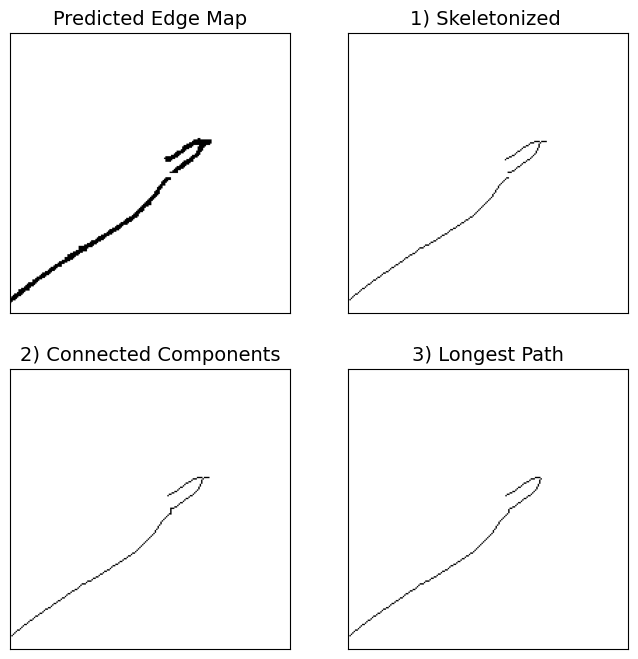

In [24]:
# Figure: data cleaning steps 

fig,ax = plt.subplots(2,2, figsize=(8,8))

i = 20
path = test_paths[26]
print(i)
ID = os.path.basename(path).split('_')[0]

# Get vegetation line prediction
image, edge_map = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1,post_process=False)

x1 = 550
x2 = -250
y1 = 200
y2 = -500

edge_map = edge_map[y1:y2, x1:x2]

edge_map[100:103] = 0

print(edge_map.shape)

# Clean the edge map
skel_edge_map = utils.thin_edge_map(edge_map)
connected_edge_map = connect_components_shortest_path(skel_edge_map)
cleaned_edge, ordered_coord = clean_edge_skeleton(connected_edge_map)

ax_flat = ax.flatten()

ax_flat[0].imshow(1-edge_map, cmap='gray')
ax_flat[0].set_title('Predicted Edge Map', fontsize=14)

ax_flat[1].imshow(1-skel_edge_map, cmap='gray')
ax_flat[1].set_title('1) Skeletonized ', fontsize=14)
ax_flat[2].imshow(1-connected_edge_map, cmap='gray')
ax_flat[2].set_title('2) Connected Components', fontsize=14)
ax_flat[3].imshow(1-cleaned_edge, cmap='gray')
ax_flat[3].set_title('3) Longest Path', fontsize=14)

for a in ax_flat:
    a.set_xticks([])
    a.set_yticks([])

figure_path = "/Users/conorosullivan/Google Drive/My Drive/1 UCD/0 research/JP02 - Vegetation Line/figures"
save_path = os.path.join(figure_path, f"postprocessing.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')